In [80]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib
import tensorflow as tf
import seaborn as sns
sns.set()
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA as sk_pca
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
#Function that plots rows on y and column labels on x
def Plot(x):
    plt.figure(figsize=(20,10))
    plt.plot(x.columns[:-1],x.iloc[:,:-1].T)
    

In [3]:
#Read all the Curucumin values into different tables
sheets_dict = pd.read_excel(r'C:\Users\Utsav Dutta\Desktop\ITC\Merged ITC Results.xlsx', sheetname=None)

a={}
for x in sheets_dict.keys():
    a[sheets_dict[x]['Curucumin'][0]]=sheets_dict[x]

l=list(a.keys())
l.sort()

#Create dataframes with index in ascending order of Curucumin values
df={}
for x in range(0,len(l)):
    df[x]=a[l[x]]
    df[x]=df[x].drop(['Reference\\','Commodity\\','isPowder\\','Scans\\','Moisture\\','Protein\\','Oil\\','Beta\\','Scale\\'],axis=1)
    df[x]['Device\\']=df[x]['Device\\'][0]
    df[x]['Curucumin']=df[x]['Curucumin'][0]
    df[x]=df[x].rename(columns = lambda x : str(x)[:-1])
    df[x]=df[x].rename(columns = {'Curucumi':'Curucumin'})

#Split into 3 dataframes for each device
df_1={}
df_2={}
df_3={}

#Reorder keys of dataframe in ascending order of Curucumin values
Df_1={}
Df_2={}
Df_3={}

for x in df.keys():
    if df[x]['Device'][0]=='809R011':
        df_1[x]=df[x]
    if df[x]['Device'][0]=='809R004':
        df_2[x]=df[x]
    if df[x]['Device'][0]=='809R001':
        df_3[x]=df[x]

for x in range(0,len(df_1.keys())):
    Df_1[x]=df_1[list(df_1.keys())[x]]
for x in range(0,len(df_2.keys())):
    Df_2[x]=df_2[list(df_2.keys())[x]]
for x in range(0,len(df_1.keys())):
    Df_3[x]=df_3[list(df_3.keys())[x]]
    
#The Df_x dataframes contain the entire spectrum of values from device X order in ascending values of Curucumin

C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


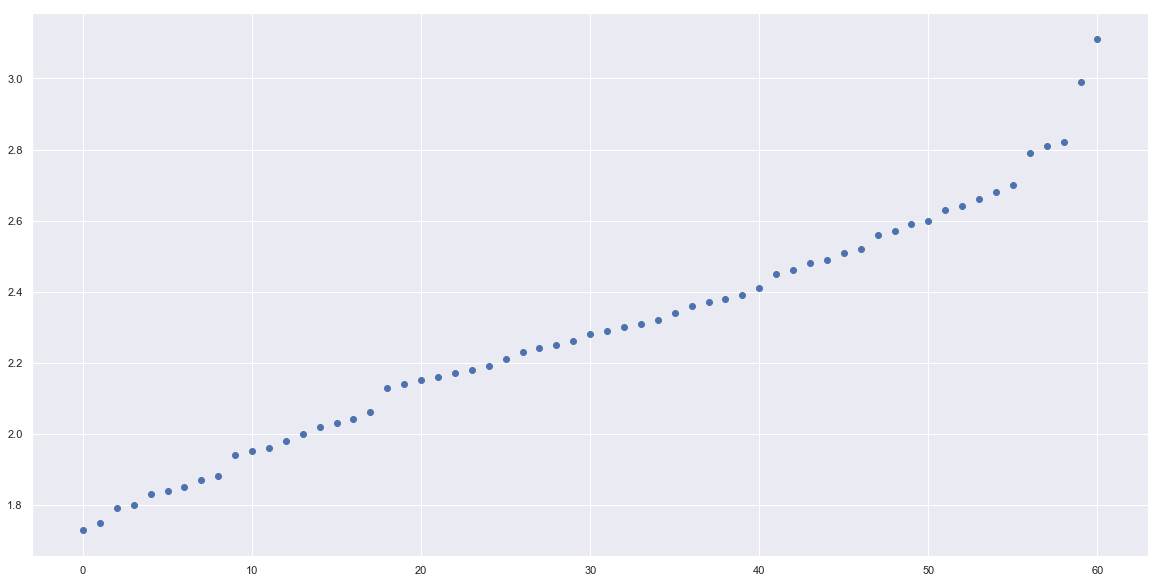

In [4]:
#plot of Curucumin values taken
hist=[]

for x in df.keys():
    hist.append(df[x]['Curucumin'][0])

plt.figure(figsize=(20,10))
plt.scatter(np.arange(0,61),hist)

#Values are mostly evenly spaced

In [5]:
#Split into 3 dataframes for each of the 3 devices. 'a' and 'r' represent absorbance and reflectance spectra
def combine_spectra_byvariable(a,var):
    b=pd.DataFrame()
    for x in a.keys():
        b=pd.concat([b,pd.DataFrame(data=[list(a[x][var])],columns=list(a[x]['Wavelength']))],ignore_index=True)
        b.loc[x,'target']=a[x]['Curucumin'][0]
    return b

In [6]:
DF_1=combine_spectra_byvariable(Df_1,'Intensity')
DF_2=combine_spectra_byvariable(Df_2,'Intensity')
DF_3=combine_spectra_byvariable(Df_3,'Intensity')
DF_1a=combine_spectra_byvariable(Df_1,'Absorbance')
DF_2a=combine_spectra_byvariable(Df_2,'Absorbance')
DF_3a=combine_spectra_byvariable(Df_3,'Absorbance')
DF_1r=combine_spectra_byvariable(Df_1,'Reflectance')
DF_2r=combine_spectra_byvariable(Df_2,'Reflectance')
DF_3r=combine_spectra_byvariable(Df_3,'Reflectance')

In [7]:
#Combine all dataframes into one
DF=pd.DataFrame( np.concatenate( (DF_1.values, DF_2.values,DF_3.values), axis=0 ),columns=DF_1.columns )
DF=DF.sort_values(['target'],ascending=True).reset_index(drop=True)

DFa=pd.DataFrame( np.concatenate( (DF_1a.values, DF_2a.values,DF_3a.values), axis=0 ),columns=DF_1a.columns )
DFa=DFa.sort_values(['target'],ascending=True).reset_index(drop=True)

DFr=pd.DataFrame( np.concatenate( (DF_1r.values, DF_2r.values,DF_3r.values), axis=0 ),columns=DF_1r.columns )
DFr=DFr.sort_values(['target'],ascending=True).reset_index(drop=True)

Standard Normal Variate Scaling

In [8]:
def snv(y):
    x=y.copy(deep=True)
    for i in range(x.shape[0]):
        x.iloc[i,:-1] = (x.iloc[i,:-1] - np.mean(x.iloc[i,:-1])) / np.std(x.iloc[i,:-1])
    return x

Multiplicative Scatter Correction

In [9]:
def msc(input_data_, reference=None):
    
    # mean centre correction
    input_data=input_data_.values[:,:-1]
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:-1].mean()

    ref = np.mean(input_data, axis=0)
    

    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    p=pd.DataFrame(data_msc,columns=input_data_.columns[:-1])
    p['target']=input_data_['target']
    return (p)

Derivative Smoothening

In [10]:
def deriv(x,y):
    a=x.copy(deep=True)
    a.iloc[:,:-1] = savgol_filter(a.iloc[:,:-1], 25, polyorder = 3,deriv=y)
    
    return a

Text(0, 0.5, 'Intensity')

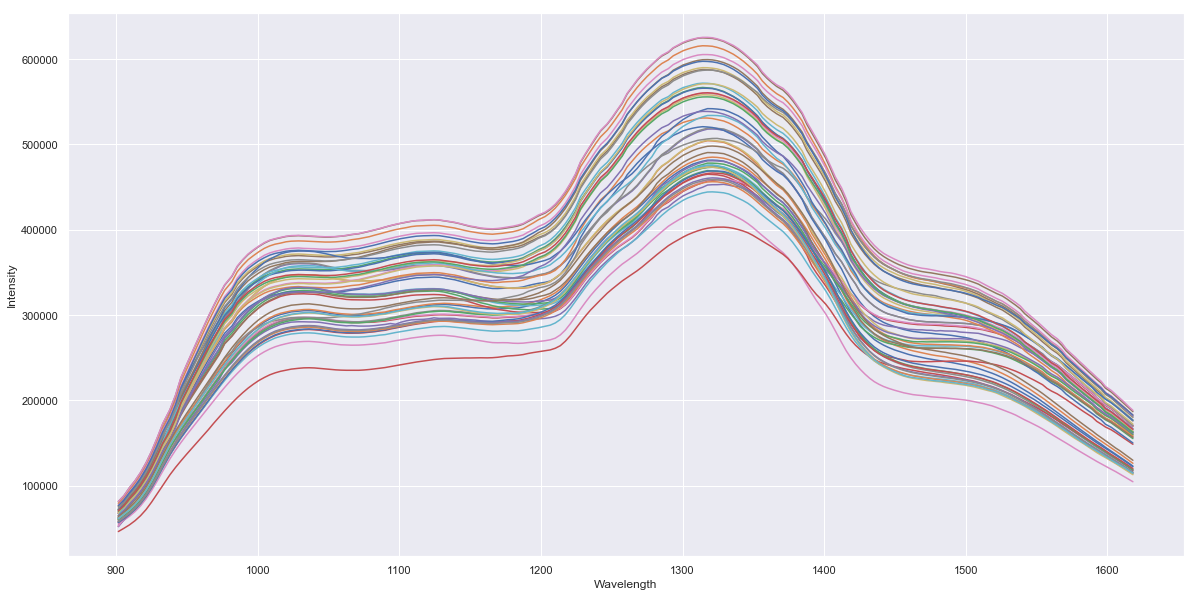

In [11]:
Plot(DF)
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

Text(0.5, 0, 'Wavelength')

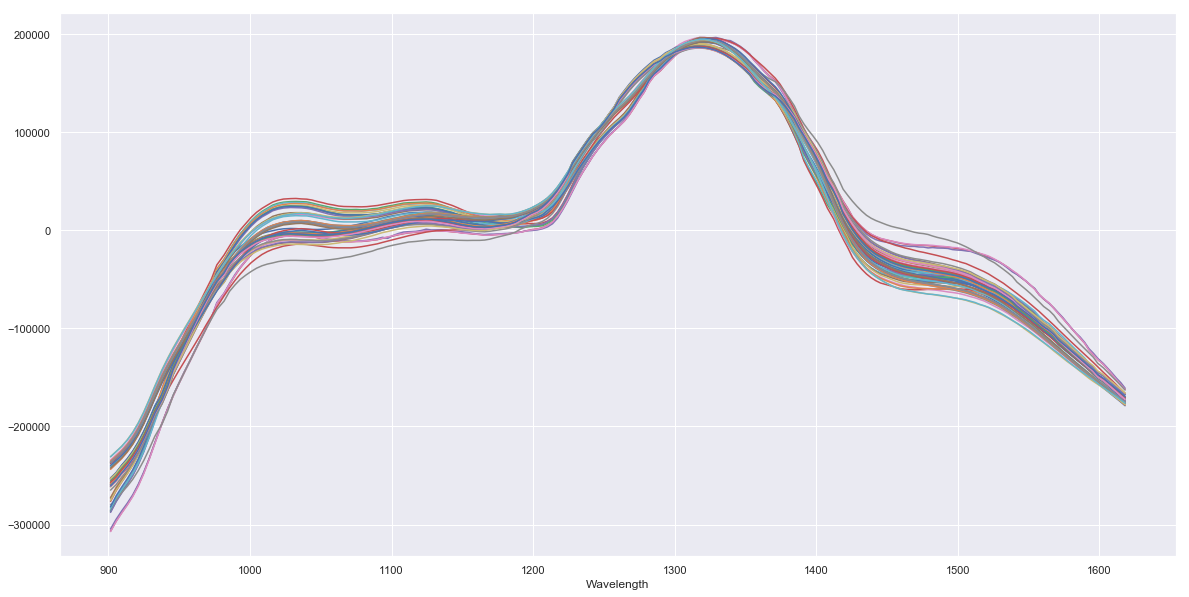

In [12]:
Plot(msc(DF))
plt.xlabel('Wavelength')

Text(0.5, 0, 'Wavelength')

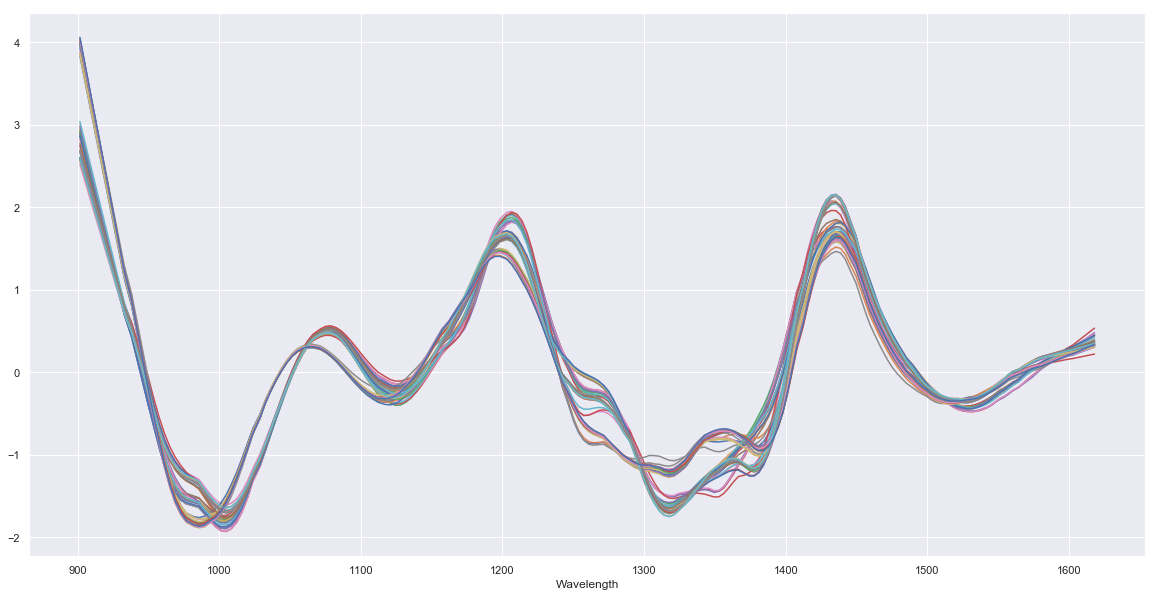

In [13]:
Plot(snv(msc(deriv(DF,2))))
plt.xlabel('Wavelength')

# Principal Components Analysis

In [14]:
def solve_pca(x,n):
    pca=PCA(n_components=n)
    y=pca.fit_transform(x.iloc[:,:-1])
    y_pca=pd.concat([pd.DataFrame(data=y,columns=['PC1','PC2']),x['target']],axis=1)
    y_pca.plot.scatter(x='PC1',y='PC2',c='target',s=60,edgecolors='k')
    

No handles with labels found to put in legend.
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


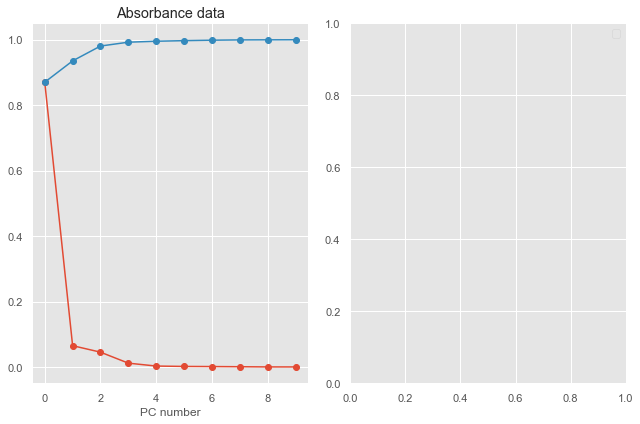

In [15]:
pca=PCA(n_components=10)

DF_pca=pca.fit(deriv(DF,2).iloc[:,:-1])

expl_var = DF_pca.explained_variance_ratio_

with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
 
    ax1.plot(expl_var,'-o', label="Explained Variance %")
    ax1.plot(np.cumsum(expl_var),'-o', label = 'Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title('Absorbance data')
   
   
 
    plt.legend()
    plt.show()

### Therefore we take first 2 principal components to model the data

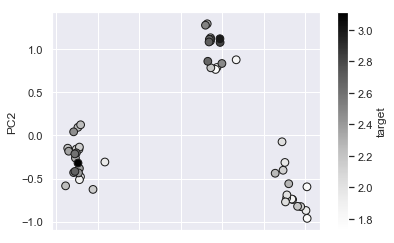

In [16]:
solve_pca(msc(snv(deriv(DF,1))),2)

#### There isn't much classification obtained through this method

# Principal Component Regression

In [17]:
def pcr(a,pc):
    
    X=a.iloc[:,:-1].copy(deep=True)
    y=a['target'].copy(deep=True)
    
    # Define the PCA object
    pca = PCA()
 
    # Preprocessing (1): first derivative
    #d1X = savgol_filter(X, 25, polyorder = 5, deriv=1)
    d1X=X.copy(deep=True)
    # Preprocess (2) Standardize features by removing the mean and scaling to unit variance
    #Xstd = StandardScaler().fit_transform(d1X[:,:])
 
    # Run PCA producing the reduced variable Xred and select the first pc components
    Xreg = pca.fit_transform(d1X)[:,:pc]
 
    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # Fit
    regr.fit(Xreg, y)
 
    # Calibration
    y_c = regr.predict(Xreg)
 
    # Cross-validation
    y_cv = cross_val_predict(regr, Xreg, y, cv=model_selection.LeaveOneOut())
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    adjusted_r2=1-(1-r2_score(y,y_cv))*((X.shape[0]-1)/(X.shape[0]-pc-1))
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    
    #plt.figure(figsize=(8,8))
    #plt.scatter(y,y_cv)
    #plt.title('$R^{2}$ (CV): '+str(score_cv))
    #plt.xlim(1.6,3.1)
    #plt.ylim(1.6,3.1)
    
    return(y_cv, score_c, score_cv, mse_c, mse_cv,adjusted_r2)

In [18]:
pcr(snv(msc(deriv(DF,1))),36)[1:]

(0.9973248114019483,
 0.9434157638575076,
 0.00027832287791719967,
 0.005886944740791032,
 0.7979134423482414)

In [43]:
def plot_r2_pca(x,n):    
    plt.figure(figsize=(11,11))
    plt.scatter(x['target'],pcr(snv(msc(deriv(x,1))),n)[0])
    plt.title('$R^{2}$ (CV): '+str(pcr(snv(msc(deriv(x,1))),n)[2]))
    plt.xlim(1.6,3.1)
    plt.ylim(1.6,3.1)

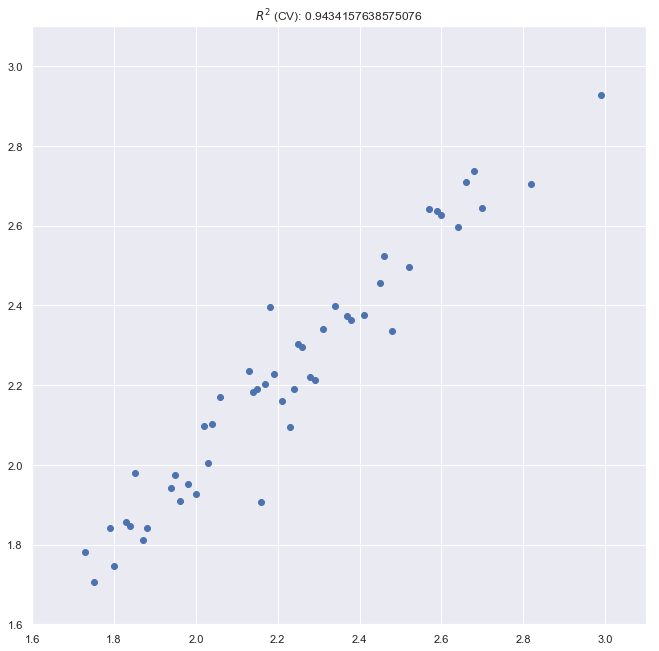

In [44]:
plot_r2_pca(DF,36)

In [45]:
def plot_adjr2_pca(x,n):    
    plt.figure(figsize=(11,11))
    plt.scatter(x['target'],pcr(snv(msc(deriv(x,1))),n)[0])
    plt.title('$R^{2}$ (CV): '+str(pcr(snv(msc(deriv(x,1))),n)[2].round(2))+'  Adjusted $R^{2}$ (CV): '+str(pcr(snv(msc(deriv(x,1))),n)[5].round(2)))
    plt.xlim(1.6,3.1)
    plt.ylim(1.6,3.1)

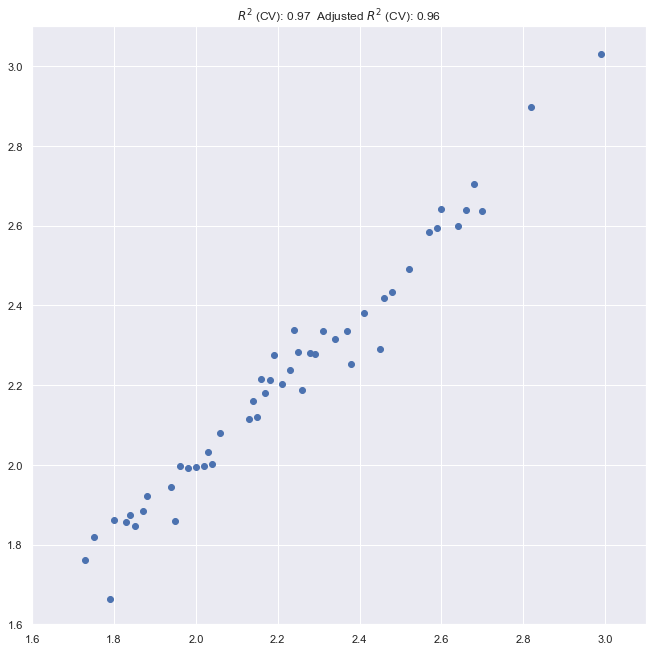

In [46]:
plot_adjr2_pca(DFa,15)

Text(0, 0.5, 'R2')

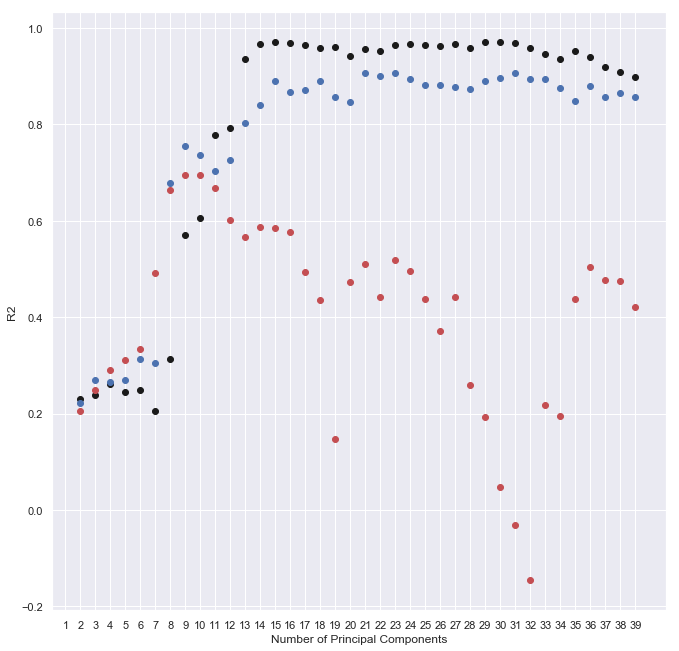

In [47]:
plt.figure(figsize=(11,11))
for i in range(2,40):
    plt.scatter(i,pcr(snv(msc(deriv(DFa,1))),i)[2],c='k')
    plt.scatter(i,pcr(snv(msc(deriv(DFa,2))),i)[2],c='b')
    plt.scatter(i,pcr(snv(msc(deriv(DFa,3))),i)[2],c='r')
plt.xticks(np.arange(1,40))
plt.xlabel('Number of Principal Components')
plt.ylabel('R2')

(0, 1)

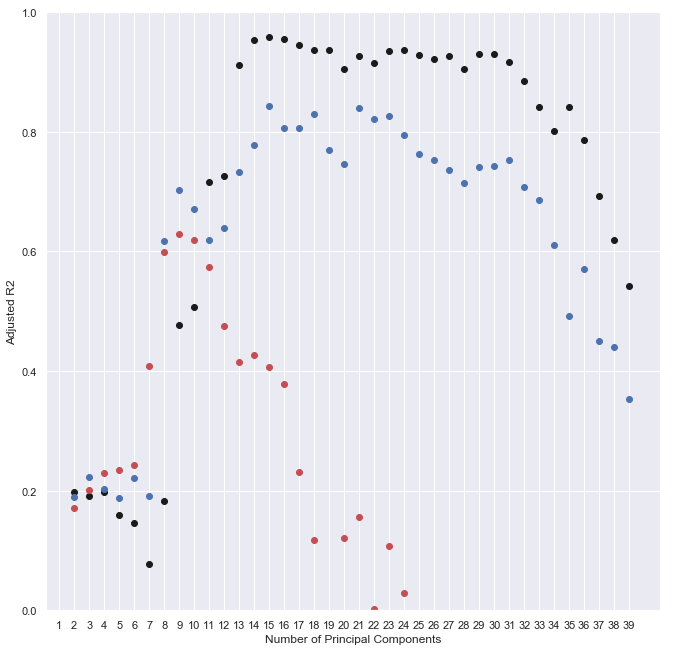

In [48]:
plt.figure(figsize=(11,11))
for i in range(2,40):
    plt.scatter(i,pcr(snv(msc(deriv(DFa,1))),i)[5],c='k')
    plt.scatter(i,pcr(snv(msc(deriv(DFa,2))),i)[5],c='b')
    plt.scatter(i,pcr(snv(msc(deriv(DFa,3))),i)[5],c='r')
plt.xticks(np.arange(1,40))
plt.xlabel('Number of Principal Components')
plt.ylabel('Adjusted R2')
plt.ylim(0,1)

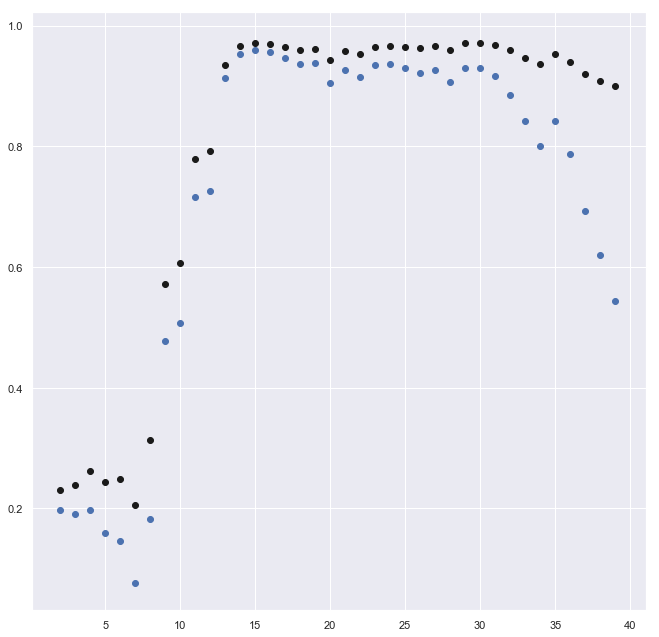

In [50]:
plt.figure(figsize=(11,11))
for i in range(2,40):
    plt.scatter(i,pcr(snv(msc(deriv(DFa,1))),i)[5],c='b')
    plt.scatter(i,pcr(snv(msc(deriv(DFa,1))),i)[2],c='k')

Text(0, 0.5, 'MSE')

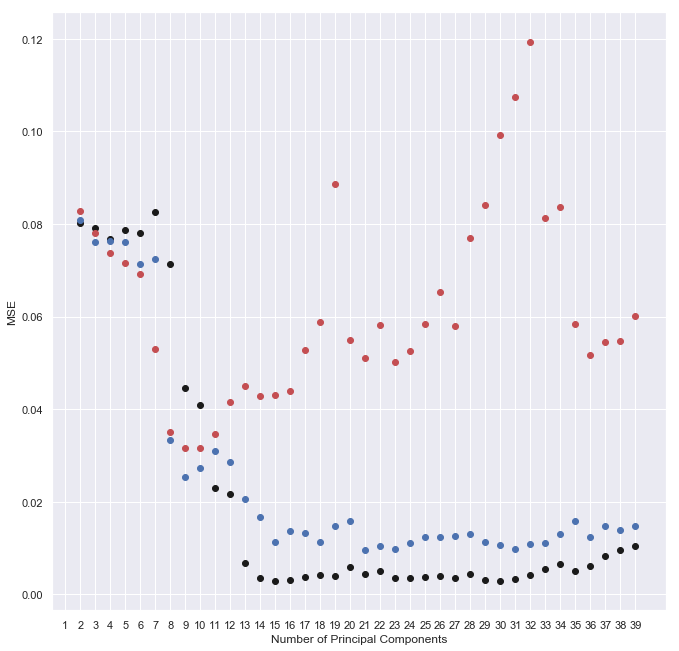

In [41]:
plt.figure(figsize=(11,11))
for i in range(2,40):
        plt.scatter(i,pcr(snv(msc(deriv(DFa,1))),i)[4],c='k')
        plt.scatter(i,pcr(snv(msc(deriv(DFa,2))),i)[4],c='b')
        plt.scatter(i,pcr(snv(msc(deriv(DFa,3))),i)[4],c='r')
plt.xticks(np.arange(1,40))
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')

# Partial Least Squares Regression

In [51]:
from sklearn.cross_decomposition import PLSRegression

In [52]:
def pls(a,pc):
    
    X=a.iloc[:,:-1].copy(deep=True)
    y=a['target'].copy(deep=True)
    
    # Define the PCA object
    pls = PLSRegression(n_components=pc)

   
 

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=model_selection.LeaveOneOut())
    
 
    # Calculate scores for calibration and cross-validation
    
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
   
    mse_cv = mean_squared_error(y, y_cv)
    adjusted_r2=1-(1-r2_score(y,y_cv))*((X.shape[0]-1)/(X.shape[0]-pc-1))
    
    
    #plt.figure(figsize=(8,8))
    #plt.scatter(y,y_cv)
    #plt.title('$R^{2}$ (CV): '+str(score_cv))
    #plt.xlim(1.6,3.1)
    #plt.ylim(1.6,3.1)
    
    return(y_cv, score_cv, mse_cv,adjusted_r2)

In [53]:
def plot_r2_pls(x,n):    
    plt.figure(figsize=(8,8))
    plt.scatter(DF['target'],pls(snv(msc(deriv(x,1))),n)[0])
    plt.title('$R^{2}$ (CV): '+str(pls(snv(msc(deriv(x,1))),n)[1]))
    plt.xlim(1.6,3.1)
    plt.ylim(1.6,3.1)

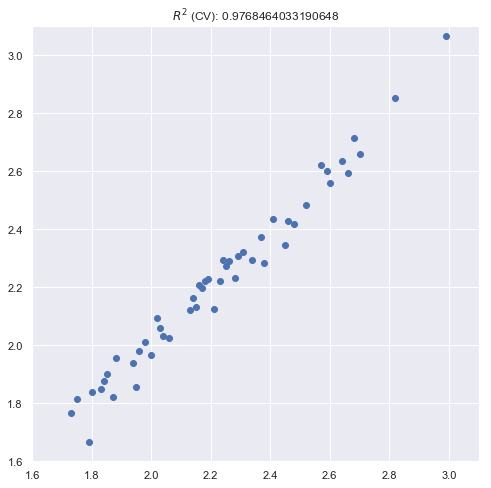

In [58]:
plot_r2_pls(DFa,14)

In [56]:
def plot_adjr2_pls(x,n):    
    plt.figure(figsize=(8,8))
    plt.scatter(DF['target'],pls(snv(msc(deriv(x,1))),n)[0])
    plt.title('$R^{2}$ (CV): '+str(pls(snv(msc(deriv(x,1))),n)[1].round(2))+'  Adjusted $R^{2}$ (CV): '+str(pls(snv(msc(deriv(x,1))),n)[3].round(2)))
    plt.xlim(1.6,3.1)
    plt.ylim(1.6,3.1)
    

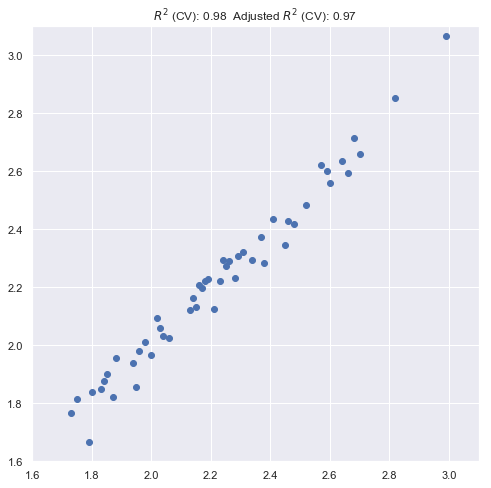

In [57]:
plot_adjr2_pls(DFa,14)

Text(0, 0.5, 'R2')

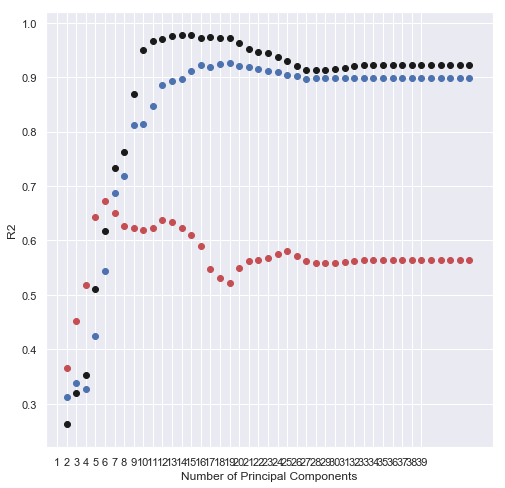

In [59]:
plt.figure(figsize=(8,8))
for i in range(2,45):
    plt.scatter(i,pls(snv(msc(deriv(DFa,1))),i)[1],c='k')
    plt.scatter(i,pls(snv(msc(deriv(DFa,2))),i)[1],c='b')
    plt.scatter(i,pls(snv(msc(deriv(DFa,3))),i)[1],c='r')
plt.xticks(np.arange(1,40))
plt.xlabel('Number of Principal Components')
plt.ylabel('R2')

Text(0, 0.5, 'Adjusted R2')

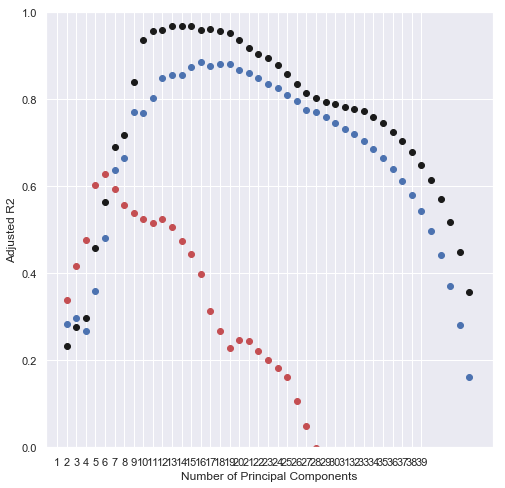

In [61]:
plt.figure(figsize=(8,8))
for i in range(2,45):
    plt.scatter(i,pls(snv(msc(deriv(DFa,1))),i)[3],c='k')
    plt.scatter(i,pls(snv(msc(deriv(DFa,2))),i)[3],c='b')
    plt.scatter(i,pls(snv(msc(deriv(DFa,3))),i)[3],c='r')
plt.xticks(np.arange(1,40))
plt.ylim(0,1)
plt.xlabel('Number of Principal Components')
plt.ylabel('Adjusted R2')

Text(0, 0.5, 'MSE')

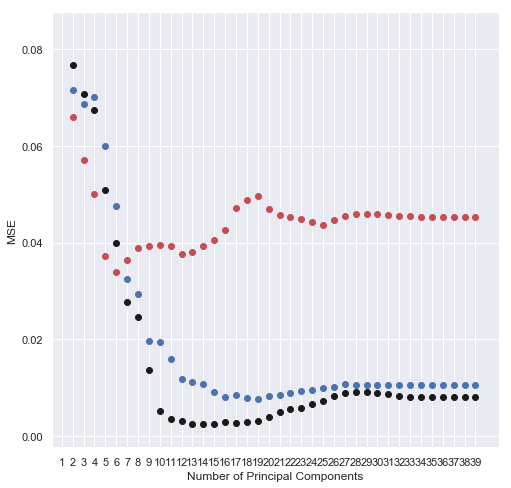

In [62]:
plt.figure(figsize=(8,8))
for i in range(2,40):
    plt.scatter(i,pls(snv(msc(deriv(DFa,1))),i)[2],c='k')
    plt.scatter(i,pls(snv(msc(deriv(DFa,2))),i)[2],c='b')
    plt.scatter(i,pls(snv(msc(deriv(DFa,3))),i)[2],c='r')
plt.xticks(np.arange(1,40))
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')

# Visualizing Variable Selection

(0, 5)

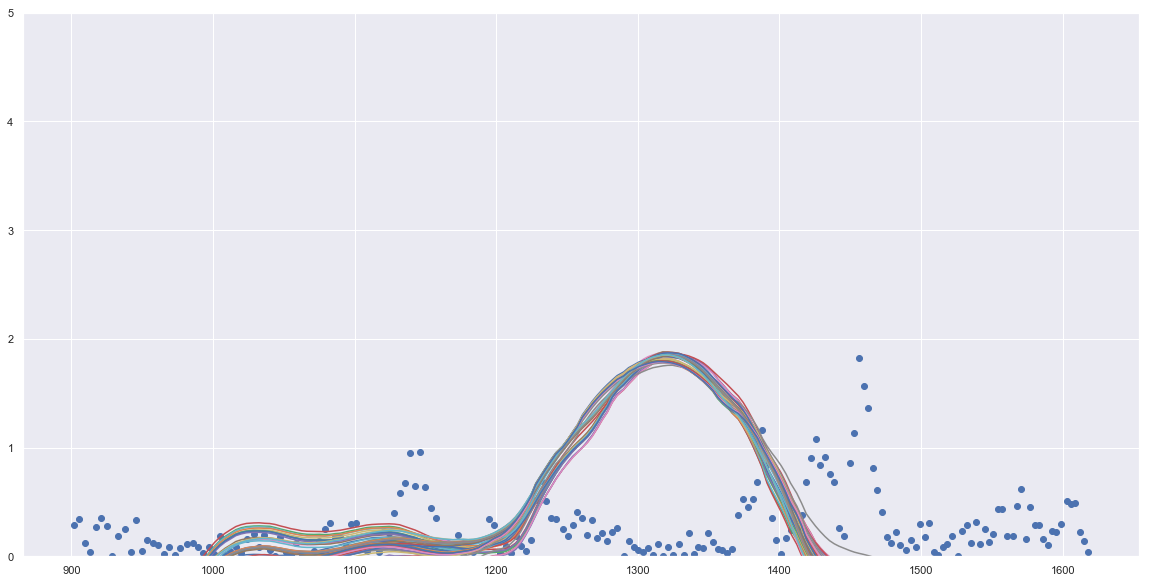

In [64]:

def pls_variable_selection(a, b, max_comp):
    
    X=a.copy(deep=True)
    y=b.copy(deep=True)
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
 
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

pls_=PLSRegression(n_components=14)

pls_.fit(DFa.iloc[:,:-1],DFa['target'])

plt.figure(figsize=(20,10))
plt.scatter(DF.columns[:-1],np.abs(pls_.coef_[:,0]))
plt.plot(DF.columns[:-1],snv(DF.iloc[:,:-1]).T)
plt.ylim(0,5)

# XGBoost

In [65]:
import xgboost as xgb

In [66]:
xg_reg = xgb.XGBRegressor(silent=True, 
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          n_estimators=1000, 
                          reg_alpha = 0.3,
                          max_depth=4, 
                          gamma=10)

In [67]:
y_cv = cross_val_predict(xg_reg, snv(deriv(DF.iloc[:,:-1],1)), DF['target'], cv=model_selection.LeaveOneOut())

r2_score(DF['target'],y_cv)

C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


-0.04058769224657066

In [ ]:

xgb1 = xgb.XGBRegressor()
parameters = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

#{'nthread':[4], #when use hyperthread, xgboost may become slower
#              'objective':['reg:linear'],
#              'learning_rate': [.03, 0.05, .07], #so called `eta` value
#              'max_depth': [5, 6, 7],
#              'min_child_weight': [4],
#              'silent': [1],
#              'subsample': [0.7],
#              'colsample_bytree': [0.7],
#              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(DF.iloc[:,:-1],DF['target'])

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

# Neural Networks

In [68]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [69]:
model=tf.keras.Sequential([
    
    layers.Dense(100,activation=tf.nn.relu,input_shape=[len(DF.columns[:-1])]),
    layers.Dense(64,activation=tf.nn.relu),
    layers.Dense(1)
])
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_squared_error'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 26,729
Trainable params: 26,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
snv(msc(deriv(DF,1))).to_csv('preprocesseddata.csv',index=False)

# Decision Trees

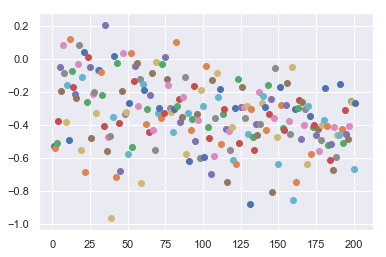

In [71]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 

for x in range(1,DF.shape[1]):
    regressor = DecisionTreeRegressor(random_state = 0,max_depth=8,min_samples_split=2,max_features=x)  

    # Cross-validation
    y_cv = cross_val_predict(regressor,DF.iloc[:,:-1] , DF['target'], cv=model_selection.LeaveOneOut())

    y=DF['target']
    plt.scatter(x,r2_score(y,y_cv))
    # Calculate scores for calibration and cross-validation
    #print(x,r2_score(y, y_cv).round(2),mean_squared_error(y, y_cv).round(2))
    
 


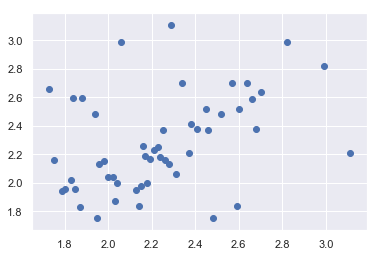

In [72]:
plt.scatter(y,y_cv)

# Random Forest Regression

In [75]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = model_selection.LeaveOneOut(), n_jobs = -1, verbose = 2)
    

In [76]:
grid_search.fit(DF.iloc[:,:-1],DF['target'])
grid_search.best_params_

Fitting 51 folds for each of 288 candidates, totalling 14688 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.7s


KeyboardInterrupt: 

In [ ]:
grid_search.best_estimator_

In [ ]:
rf=grid_search.best_estimator_

In [77]:
y_cv = cross_val_predict(rf, DF.iloc[:,:-1],DF['target'], cv=model_selection.LeaveOneOut())

C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\skl

C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\skl

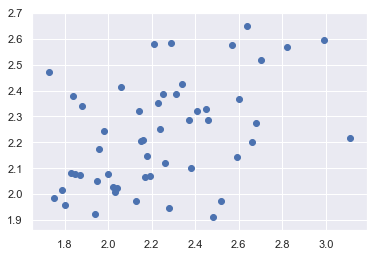

In [78]:
plt.scatter(y,y_cv)

# Linear Discrimant Analysis

In [88]:
DFa_binned=DFa.copy(deep=True)
DFa_binned['target']=pd.cut(DFa['target'],bins=[1.70,1.90,2.10,2.30,2.50,2.70,2.90,3.10,3.30],labels=[1,2,3,4,5,6,7,8])

In [163]:
X=DFa_binned.iloc[:,:-1]
y=DFa_binned['target']

lda = LDA(n_components=3)
Xlda = lda.fit_transform(X,y)

C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [214]:
dataframe=pd.DataFrame(data=Xlda,columns=['LDA1','LDA2','LDA3'])

In [215]:
dataframe['target']=DFa_binned['target']

In [216]:
sns.set(rc={'figure.figsize':(20,10)})

3D Plot

In [217]:
%matplotlib notebook

<IPython.core.display.Javascript object>


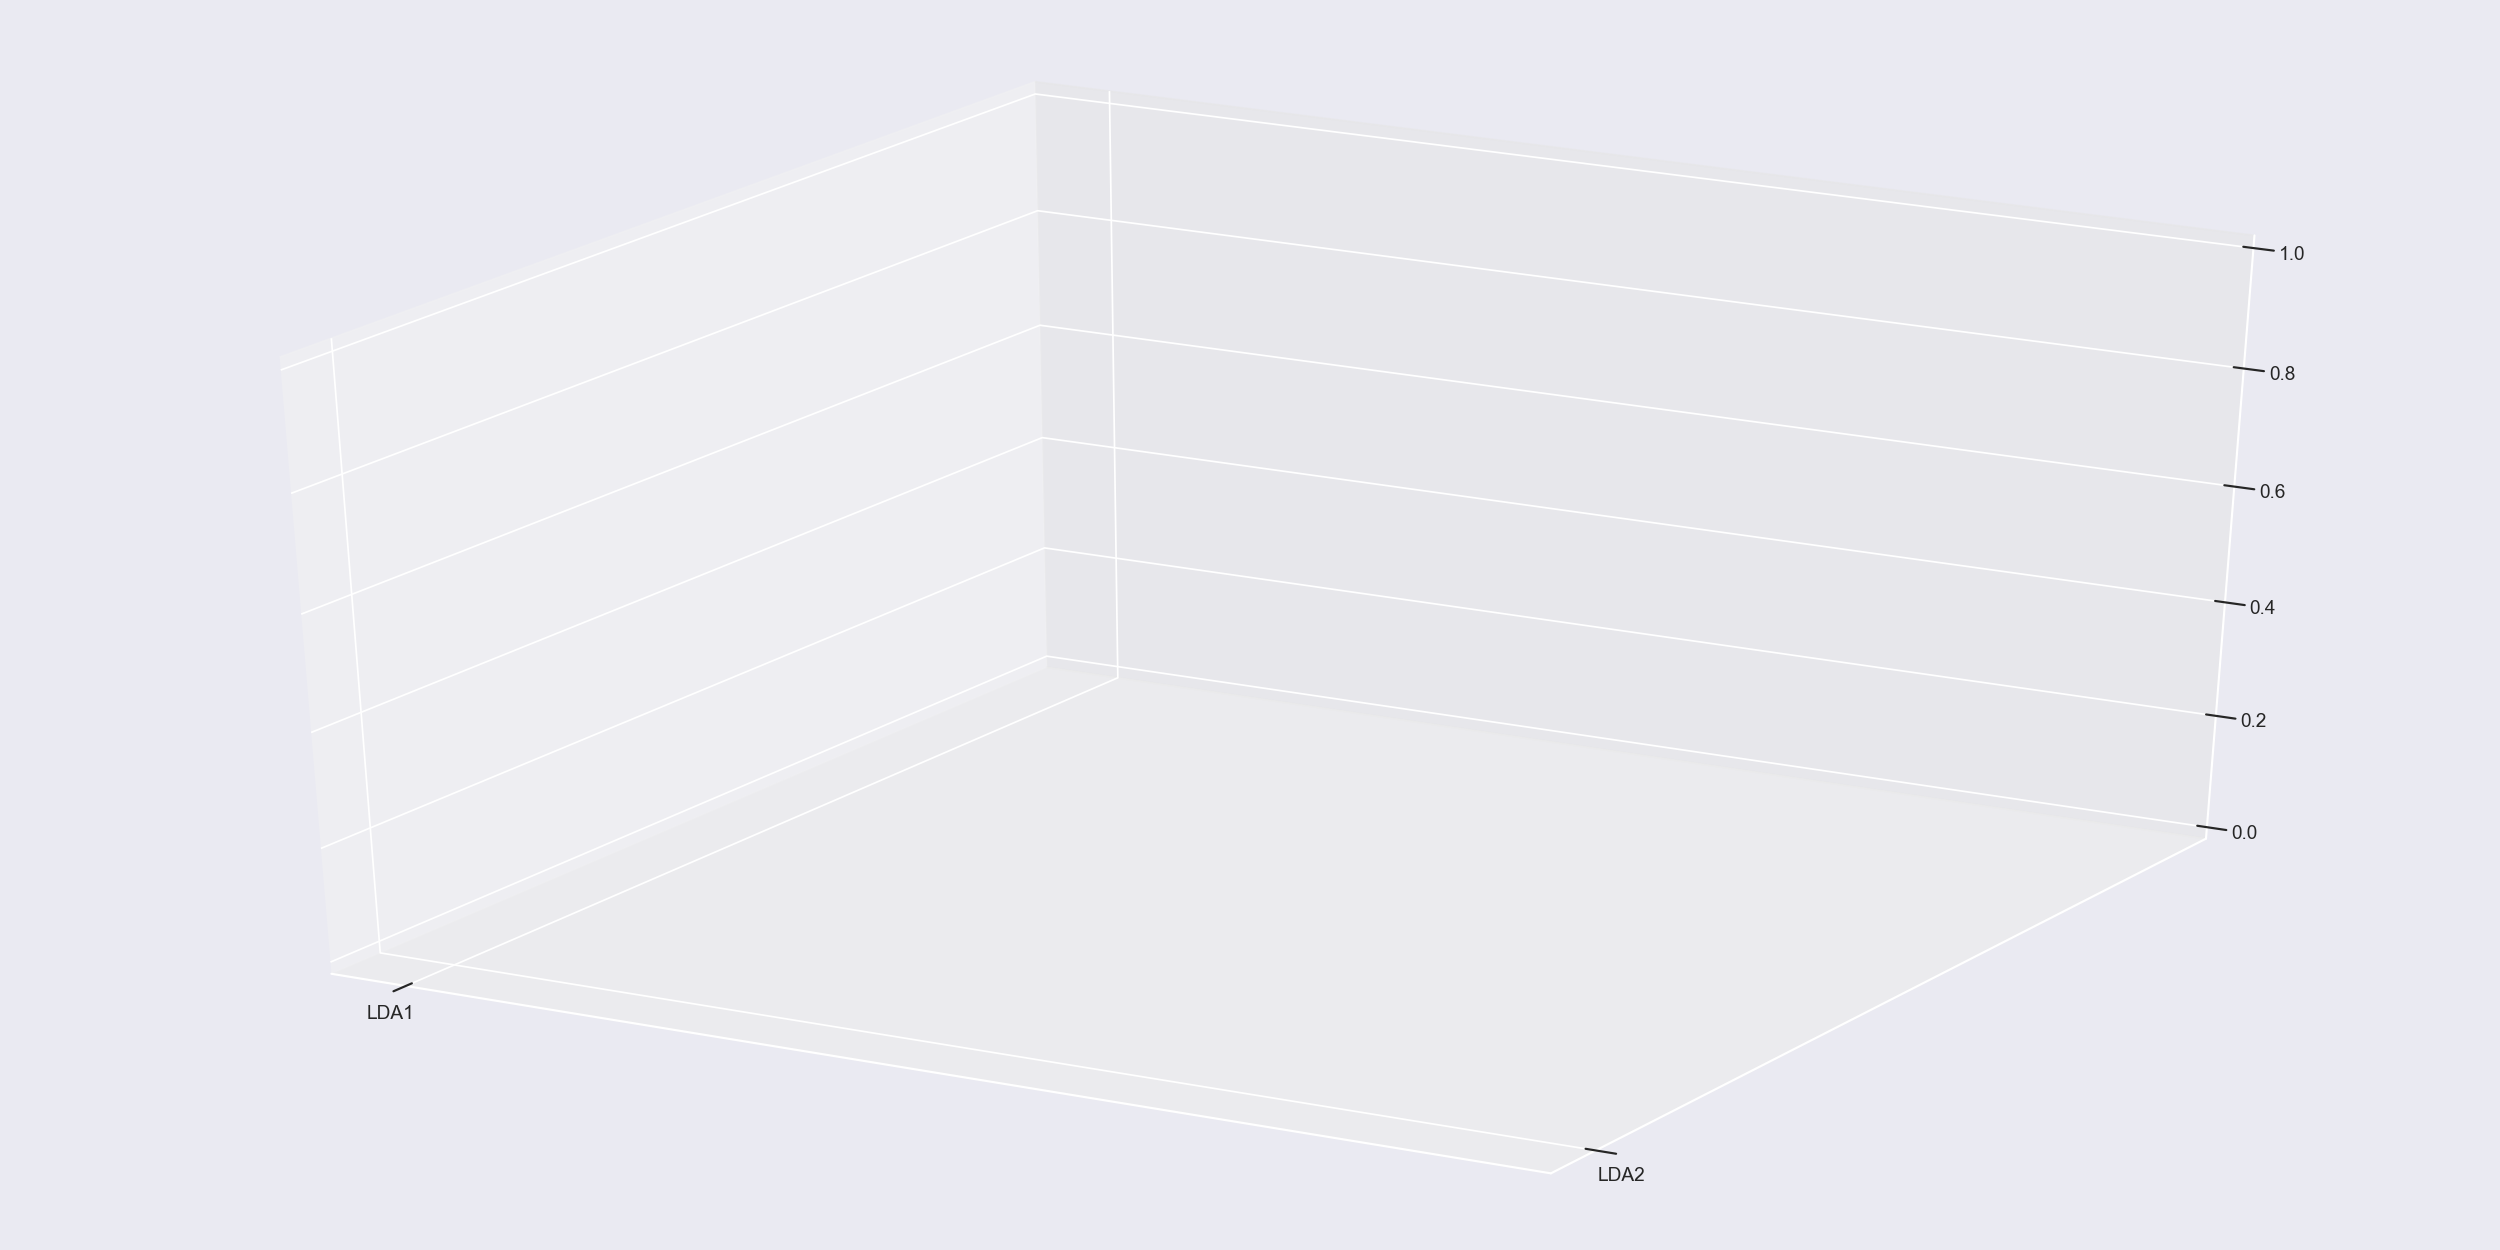

ValueError: 'c' argument has 51 elements, which is not acceptable for use with 'x' with size 1, 'y' with size 1.

In [222]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)



ax.scatter('LDA1','LDA2','LDA3',c=dataframe['target'],s=50,cmap='viridis',marker='o',edgecolors='k')
ax.legend()
plt.colorbar()
pyplot.show()

# Testing New Data

In [409]:
a=pd.read_csv('C:/Users/Utsav Dutta/Desktop/ITC/test2.csv',skiprows=[0,1,2])

TEST1=pd.DataFrame([list(a['Absorbance'][0:201])],columns=DF.columns[0:201])
TEST1['target']=0

pls=PLSRegression(n_components=14)
pls.fit(snv(msc(deriv(DFa,1))).iloc[:,:-1],DFa['target'])
pls.predict(snv(msc(deriv(TEST1,1))).iloc[:,:-1]).ravel()[0].round(2)

2.93